In [1]:
%%capture --no-display
%pip install 'transformers[sentencepiece]'
%pip install 'transformers[torch]'
%pip install accelerate -U
%pip install matplotlib
%pip install torch
%pip install -U scikit-learn

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from transformers import pipeline, TrainingArguments, Trainer, AdamW, get_linear_schedule_with_warmup, BertForSequenceClassification, BertTokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import os
from BertClassifier import BertClassifier

In [4]:
triplets_path = f'{os.getcwd()}/triplets'

In [5]:
lexical_functions = ['_ANTIBON', '_ANTIMAGN', '_ANTIVER', '_BON', '_MAGN', '_OPER1', '_OPER2', '_VER']

In [6]:
triplets = {}

for lf in lexical_functions:
    triplets[lf] = pd.read_csv(f'{triplets_path}/{lf}.csv')

<BarContainer object of 8 artists>

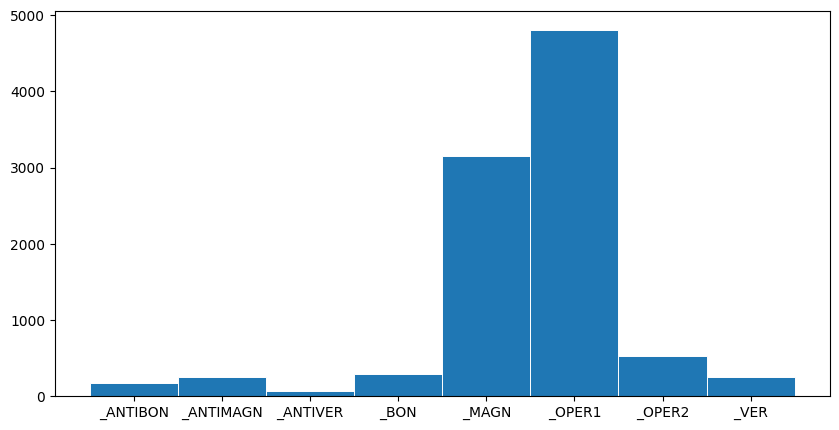

In [7]:
fig = plt.figure(figsize = (10, 5))

plt.bar(lexical_functions, [len(triplets[lf]) for lf in lexical_functions], width=1, edgecolor="white", linewidth=0.7)

In [8]:
dataset = pd.concat([triplets[lf] for lf in lexical_functions]).dropna()

In [9]:
label_encoder = LabelEncoder()
encoder = label_encoder.fit(lexical_functions)
target = encoder.transform(dataset['function'].values)
classes = encoder.transform(lexical_functions)

In [10]:
def train_val_test_split(X, y, train_size, val_size, test_size):
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = test_size, stratify=y)
    relative_train_size = train_size / (val_size + train_size)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                      train_size = relative_train_size, test_size = 1-relative_train_size, stratify=y_train_val)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [11]:
X = dataset.drop(['function'], axis=1)
y = dataset['function']

In [12]:
train_ratio = 0.60
validation_ratio = 0.10
test_ratio = 0.30


X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, y, train_ratio, validation_ratio, test_ratio)

In [14]:
model = BertClassifier(model_path='sberbank-ai/ruBert-base',
                       tokenizer_path='sberbank-ai/ruBert-base',
                       max_len=256,
                       label_encoder=encoder,
                       n_classes=len(lexical_functions),
                       epochs=5,
                       batch_size=4,
                       model_save_path=f'{os.getcwd()}/model/ruBert_lf.pt')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sberbank-ai/ruBert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
model.prepare(X_train, y_train, X_val, y_val)

/home/dary/.local/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [16]:
model.train()

Epoch 1/5


In [ ]:
model_bert = BertClassifier(model_path='google-bert/bert-base-multilingual-cased',
                       tokenizer_path='google-bert/bert-base-multilingual-cased',
                       max_len=256,
                       label_encoder=encoder,
                       n_classes=len(lexical_functions),
                       epochs=5,
                       batch_size=4,
                       model_save_path=f'{os.getcwd()}/model/bert_lf.pt')

In [ ]:
model_bert.prepare(X_train, y_train, X_val, y_val)

In [ ]:
model_bert.train()